### KU ID: vfd881

In [1]:
import numpy as np
import sympy as sp
import scipy as sc
import matplotlib.pyplot as plt
import iminuit
import scipy.stats as stats
from IPython.display import display, Math, Latex
from scipy.integrate import quad
from scipy.stats import rv_continuous
from iminuit import Minuit, cost
from scipy import stats
from scipy.optimize import curve_fit, root_scalar
import pandas as pd

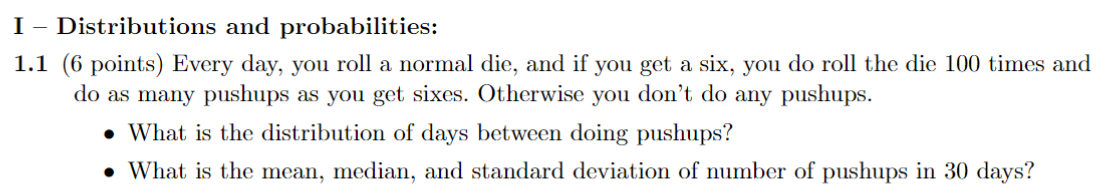

- Here I will use a geometric distribution, as it will give me the probaility of the first success happening on the nth trial. This I can use to plot the   distribution of the days it will take to get a six and therefore plot it.

- While the exact distribution of total pushups comes from a binomial distribution, the Central Limit Theorem (CLT) says that the sum of random variables (here, total pushups) often approaches a normal distribution. Therefore normal distribution provides a good approximation for the histogram

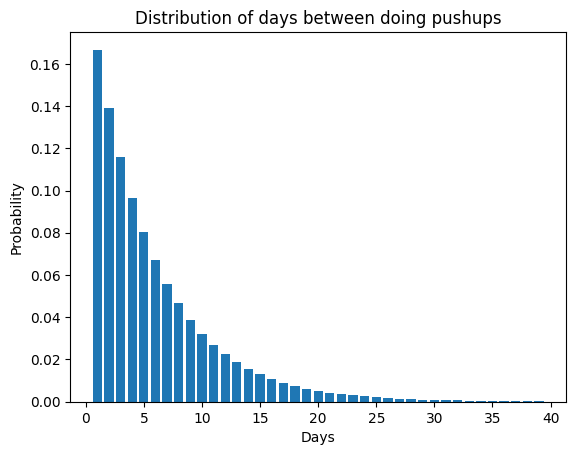

Mean number of pushups in 30 days: 83.654 
Standard deviation of number of pushups in 30 days: 35.94284746649881 
Median number of pushups in 30 days: 82.0


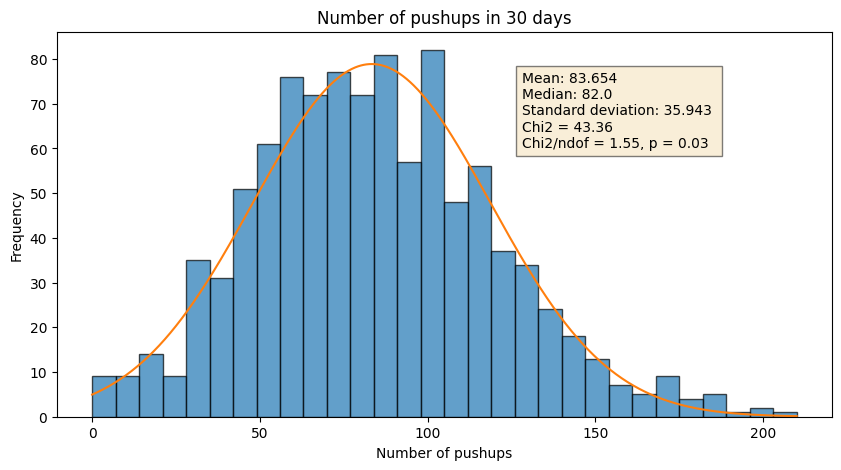

In [2]:
#Every day, you roll a normal die, and if you get a six, you do roll the die 100 times and do as many pushups as you get sixes. Otherwise you don’t do any pushups.
 
#What is the distribution of days between doing pushups

p = 1/6
n = 100
def prob(n):
    return (1-p)**(n-1)*p

x = np.arange(1, 40)
pmf = stats.geom.pmf(x, p)

plt.bar(x, pmf)
plt.xlabel('Days')
plt.ylabel('Probability')
plt.title('Distribution of days between doing pushups')
plt.show()

#What is the mean, median, and standard deviation of number of pushups in 30 days?
days = 30
die_rolls = 100

r = np.random.seed(42) #I set the seed so that the results are reproducible

total_pushups = []

for i in range(1000):
    daily_pushups = []
    for j in range(days):
        if np.random.rand() < p:
            daily_pushups.append(np.random.binomial(die_rolls, p))
        else:
            daily_pushups.append(0)
    total_pushups.append(sum(daily_pushups))

mean = np.mean(total_pushups)
median = np.median(total_pushups)
std = np.std(total_pushups)

print(f'Mean number of pushups in 30 days: {mean} \nStandard deviation of number of pushups in 30 days: {std} \nMedian number of pushups in 30 days: {median}')

# n = days*die_rolls
# binom_p = p/die_rolls #probability of getting a six in one roll
# binom_x =np.arange(min(total_pushups), max(total_pushups)+1)
# binom_pmf = stats.binom.pmf(binom_x, n, binom_p)




fig, ax = plt.subplots(figsize=(10, 5))
counts, edges, _ = plt.hist(total_pushups, bins=30, range=(min(total_pushups), max(total_pushups)) ,edgecolor='black', alpha=0.7)
# counts, edges = np.histogram(total_pushups, bins=30, range=(min(total_pushups), max(total_pushups)), density=True)
x = (edges[1:] + edges[:-1])/2
x = x[counts > 0]
y = counts[counts > 0]
y_err = np.sqrt(y)

xmax = max(total_pushups)
xmin = min(total_pushups)

def gauss(x, mean, std):
    k = (xmax-xmin)/30
    N = 1000*k
    return N*stats.norm.pdf(x, mean, std)

# ax.errorbar(x, y, y_err, fmt='o', color='black', label='Histogram of number of pushups')

fit = cost.LeastSquares(x, y, y_err, gauss)
m = Minuit(fit, mean=mean, std=std)
m.migrad()

chi2 =m.fval
ndof = len(x) - len(m.values)
p_value = stats.chi2.sf(chi2, ndof)

x_gauss = np.linspace(min(total_pushups), max(total_pushups), 1000)
y_gauss = gauss(x_gauss, m.values['mean'], m.values['std'])

ax.plot(x_gauss, y_gauss, label='Normal distribution')
# ax.hist(total_pushups, bins=30, edgecolor='black', density=True, alpha=0.7, label='Histogram of number of pushups')
ax.text(0.6, 0.7, f'Mean: {mean}\nMedian: {median}\nStandard deviation: {std:.3f} \nChi2 = {chi2:.2f} \nChi2/ndof = {chi2/ndof:.2f}, p = {p_value:.2f} ', transform=ax.transAxes,
    bbox=dict(facecolor='wheat', alpha=0.5))
ax.set_xlabel('Number of pushups')
ax.set_ylabel('Frequency')
ax.set_title('Number of pushups in 30 days')
plt.show()


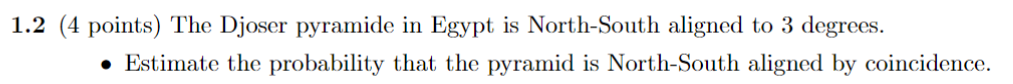

If it's by coincidence then I can assume a uniform probability distribution of angles it could be alligned with over 360 degrees. I will run a simulation to see how many fall in the range of 3 degrees

In [4]:
Degrees = 360
range_angle = 6
simulation = 1000

aligned = []

for i in range(simulation):
    random_angle = np.random.uniform(0, Degrees)
    if random_angle < range_angle:
        aligned.append(1)
    else:
        aligned.append(0)

prob = sum(aligned)/simulation
print(f'Probability of being aligned by coincidence: {prob}')


Probability of being aligned: 0.021


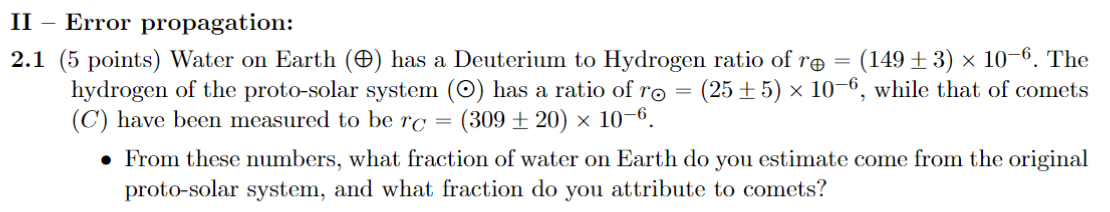

To do this I assume a linear correlation between the ratio of water on earth and the ratios of water coming from the protosolar system and the comet.

$ r_E = f_p \cdot r_p + f_c \cdot r_c $

where $ r_E $ is the ratio of water on earth, $ f_p $ is the fraction of water coming from the protosolar system, $ r_p $ is the ratio of water in the protosolar system, $ f_c $ is the fraction of water coming from the comet, and $ r_c $ is the ratio of water in the comet.

This also means:

$ f_p + f_c = 1 $

$ r_E = f_p \cdot r_p + (1 - f_p) \cdot r_c $

$ f_p = \frac{r_c - r_E}{r_c - r_p} $

$ f_c = 1 - f_p $

In [5]:
r_E = 149e-6
r_E_err = 3e-6

r_P = 25e-6
r_P_err = 5e-6

r_C = 309e-6
r_C_err = 20e-6

f_p = (r_C - r_E)/(r_C - r_P) #Fraction from proto-solar
f_C = 1 - f_p #Fraction from comet

f_p_error = np.sqrt((r_E_err/(r_C -r_P))**2 + (r_C_err*(r_E -r_P)/(r_C - r_P)**2)**2 + r_P_err*(r_C - r_E)/(r_C - r_P)**2)
f_C_error = np.sqrt((r_E_err/(r_C -r_P))**2 + (r_C_err*(r_P -r_E)/(r_C - r_P)**2)**2 + r_P_err*(r_C - r_P)/(r_C - r_P)**2)

print(f'Fraction of proto-solar material: {f_p:.3f} ± {f_p_error:.3f} \nFraction of comet material: {f_C:.3f} ± {f_C_error:.3f}')

Fraction of proto-solar material: 0.563 ± 0.105 
Fraction of comet material: 0.437 ± 0.137


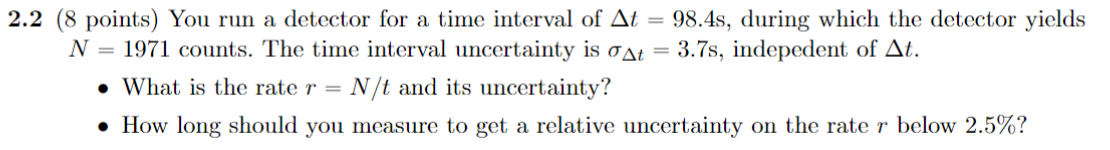

For the uncertainty on the counts I assume it follows a poisson distribution, and the error will be square root of the counts.

In [9]:
t = 98.4
t_err = 3.7
N = 1971
N_err = np.sqrt(N)

r = N/t
r_err = np.sqrt((N_err/t)**2 + (N*t_err/t**2)**2)
print(f'Rate of decay: {r:.3f} ± {r_err:.3f} decays/s')
print(f'Relative error of rate of decay: {r_err/r:.3f}')

Rate of decay: 20.030 ± 0.878 decays/s
Relative error of rate of decay: 0.044


I will run a simulation over a range of t's to see how the error changes with the counts and find when the relative error is less than 2.5%. I will start at t = 98.4, since I know that gives a relative rate of 4.4%. I will do in stepsizes of 0.1 s

$ \frac{\sigma_r}{r} < 0.025 $

In [16]:
def relative_err(t_guess):
    return (np.sqrt((N_err/t_guess)**2 + (N*t_err/t_guess**2)**2)*t_guess)/N

rel_error = 1
t_range = np.arange(98.4, 500, 0.1)
i = 0
for i in range(len(t_range)):
    rel_error = relative_err(t_range[i])
    if rel_error < 0.025:
        print(f'The time needed for a relative error of 2.5% is: {t_range[i]:.1f} s')
        print(f'The relative error at this time is: {rel_error:.3f}')
        break



The time needed for a relative error of 2.5% is: 341.2 s
The relative error at this time is: 0.025


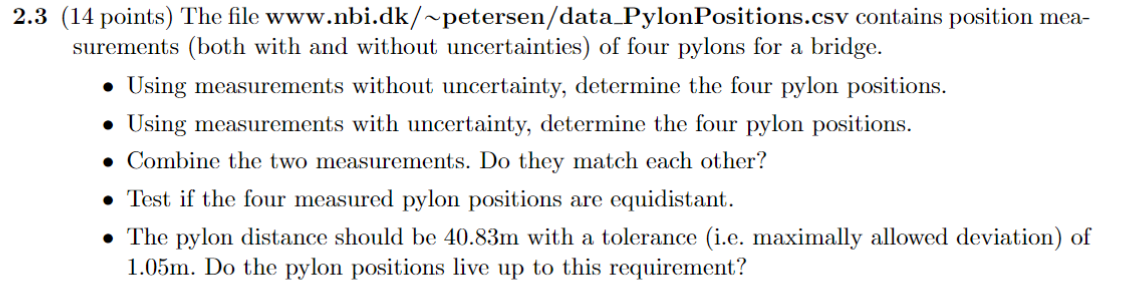

(80, 2)
(40, 2)


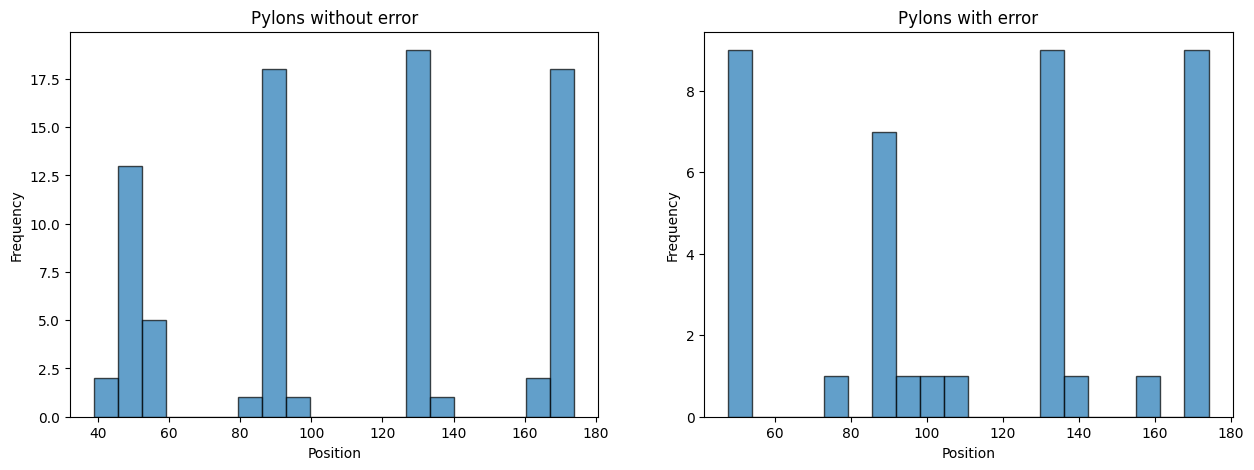

In [ ]:
Pylons = pd.read_csv('data_PylonPositions.csv')
Pylons_no_err = Pylons[Pylons['  Uncertainty'] == -1]
Pylons_w_err = Pylons[Pylons['  Uncertainty'] != -1]
print(Pylons_no_err.shape)
print(Pylons_w_err.shape)

fig,ax = plt.subplots(1,2,figsize=(15, 5))
ax[0].hist(Pylons_no_err['# Position'], bins=20, edgecolor='black', alpha=0.7, label='Pylons without error')
ax[1].hist(Pylons_w_err['# Position'], bins=20, edgecolor='black', alpha=0.7, label='Pylons with error')
ax[0].set_xlabel('Position')
ax[0].set_ylabel('Frequency')
ax[0].set_title('Pylons without error')
ax[1].set_xlabel('Position')
ax[1].set_ylabel('Frequency')
ax[1].set_title('Pylons with error')
plt.show()


I will start with the pylons without error, where it is very easy to see the 4 pylons as seen on the histogram. As they don't have any uncertainty, I will simply take the mean of the 4 peaks as the position of the pylons. Furthermore I will use chauvenet's criterion to remove the outliers, if there is any. To do this I will use student's t-distribution to test for outliers as the varience is unknown and N is small.

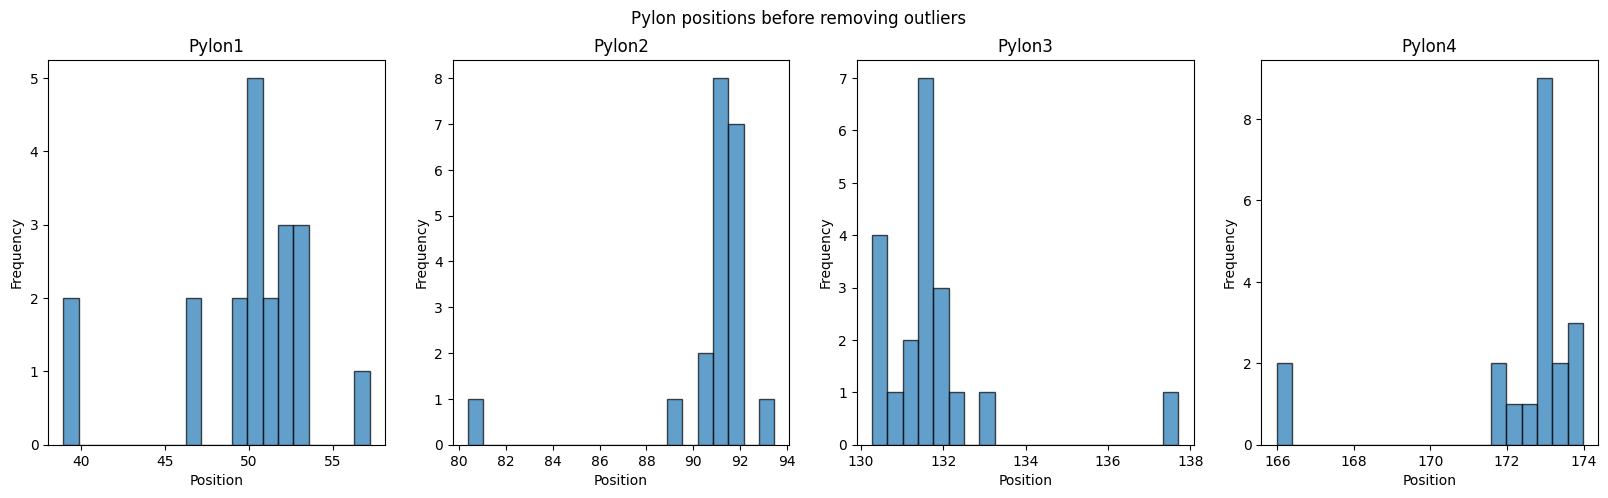

Good data in Pylon1: 15 
Bad data in Pylon1: 5
Good data in Pylon2: 16 
Bad data in Pylon2: 4
Good data in Pylon3: 18 
Bad data in Pylon3: 2
Good data in Pylon4: 14 
Bad data in Pylon4: 6
Pylon1 position: 51.30 ± 0.33 
Pylon2 position: 91.36 ± 0.11 
Pylon3 position: 131.39 ± 0.14 
Pylon4 position: 173.10 ± 0.09


In [59]:
Pylon1_no_error = Pylons_no_err['# Position'][Pylons_no_err['# Position'] < 70]
Pylon2_no_error = Pylons_no_err['# Position'][(Pylons_no_err['# Position'] > 70) & (Pylons_no_err['# Position'] < 110)]
Pylon3_no_error = Pylons_no_err['# Position'][(Pylons_no_err['# Position'] > 110) & (Pylons_no_err['# Position'] < 150)]
Pylon4_no_error = Pylons_no_err['# Position'][Pylons_no_err['# Position'] > 150]

fig,ax = plt.subplots(1,4,figsize=(20, 5))
ax[0].hist(Pylon1_no_error, bins=20, edgecolor='black', alpha=0.7, label='Pylon1')   
ax[1].hist(Pylon2_no_error, bins=20, edgecolor='black', alpha=0.7, label='Pylon2')
ax[2].hist(Pylon3_no_error, bins=20, edgecolor='black', alpha=0.7, label='Pylon3')
ax[3].hist(Pylon4_no_error, bins=20, edgecolor='black', alpha=0.7, label='Pylon4')
ax[0].set_xlabel('Position')
ax[0].set_ylabel('Frequency')
ax[0].set_title('Pylon1')
ax[1].set_xlabel('Position')
ax[1].set_ylabel('Frequency')
ax[1].set_title('Pylon2')
ax[2].set_xlabel('Position')
ax[2].set_ylabel('Frequency')
ax[2].set_title('Pylon3')
ax[3].set_xlabel('Position')
ax[3].set_ylabel('Frequency')
ax[3].set_title('Pylon4')
fig.suptitle('Pylon positions before removing outliers')
plt.show()

def chauvenet(data):
    bad_data = []
    good_data = np.array(data)
    check = True
    while check:
        N = len(good_data)
        mean = good_data.mean()
        std = good_data.std(ddof=1)
        # z = N*sc.special.erfc(abs(good_data-mean)/(std))
        t = N*stats.t.sf(abs(good_data-mean)/(std), N-1)
        p = stats.norm.sf(t)
        idx = np.argmin(t)
        # print(p[idx])
        # print(z[idx])
        if t[idx] < 0.5:
            bad_data.append(good_data[idx])
            good_data = np.delete(good_data, idx)
        else:
            check = False
    return good_data, bad_data

Pylon1_good, Pylon1_bad = chauvenet(Pylon1_no_error)
Pylon2_good, Pylon2_bad = chauvenet(Pylon2_no_error)
Pylon3_good, Pylon3_bad = chauvenet(Pylon3_no_error)
Pylon4_good, Pylon4_bad = chauvenet(Pylon4_no_error)
print(f'Good data in Pylon1: {len(Pylon1_good)} \nBad data in Pylon1: {len(Pylon1_bad)}')
print(f'Good data in Pylon2: {len(Pylon2_good)} \nBad data in Pylon2: {len(Pylon2_bad)}')
print(f'Good data in Pylon3: {len(Pylon3_good)} \nBad data in Pylon3: {len(Pylon3_bad)}')
print(f'Good data in Pylon4: {len(Pylon4_good)} \nBad data in Pylon4: {len(Pylon4_bad)}')

Pylon1_pos = np.mean(Pylon1_good)
Pylon1_pos_err = np.std(Pylon1_good)/np.sqrt(len(Pylon1_good))

Pylon2_pos = np.mean(Pylon2_good)
Pylon2_pos_err = np.std(Pylon2_good)/np.sqrt(len(Pylon2_good))

Pylon3_pos = np.mean(Pylon3_good)
Pylon3_pos_err = np.std(Pylon3_good)/np.sqrt(len(Pylon3_good))

Pylon4_pos = np.mean(Pylon4_good)
Pylon4_pos_err = np.std(Pylon4_good)/np.sqrt(len(Pylon4_good))

print(f'Pylon1 position: {Pylon1_pos:.2f} ± {Pylon1_pos_err:.2f} \nPylon2 position: {Pylon2_pos:.2f} ± {Pylon2_pos_err:.2f} \nPylon3 position: {Pylon3_pos:.2f} ± {Pylon3_pos_err:.2f} \nPylon4 position: {Pylon4_pos:.2f} ± {Pylon4_pos_err:.2f}')

fig,ax = plt.subplots(1,4,figsize=(20, 5))
ax[0].hist(Pylon1_good, bins=20, edgecolor='black', alpha=0.7, label='Pylon1')   
ax[1].hist(Pylon2_good, bins=20, edgecolor='black', alpha=0.7, label='Pylon2')
ax[2].hist(Pylon3_good, bins=20, edgecolor='black', alpha=0.7, label='Pylon3')
ax[3].hist(Pylon4_good, bins=20, edgecolor='black', alpha=0.7, label='Pylon4')
ax[0].set_xlabel('Position')
ax[0].set_ylabel('Frequency')
ax[0].set_title('Pylon1')
ax[1].set_xlabel('Position')
ax[1].set_ylabel('Frequency')
ax[1].set_title('Pylon2')
ax[2].set_xlabel('Position')
ax[2].set_ylabel('Frequency')
ax[2].set_title('Pylon3')
ax[3].set_xlabel('Position')
ax[3].set_ylabel('Frequency')
ax[3].set_title('Pylon4')
fig.suptitle('Pylon positions before removing outliers')
plt.show()
